# Analiza slik z nevronskimi mrežami

## 3. Razgradnja slik z nevronskimi mrežami

### Motivacija

Razgradnjo MRI slik pri bolnikih z multiplo sklerozo je klinično motivirana. Preko razgradnje lahko izvajamo meritve razgrajenih struktur, kot so prostornina bele in sive možganovine, prostorina in število patoloških lezij, ipd. Te meritve, npr. prostornina zdravih možganskih struktur in patoloških lezij odražata stanje bolezni, pri čemer na prvo vpliva pospešena nevrodegeneracija pri pospešenem poteku bolezni, druga pa je odraz akutne vnetne aktivnosti bolezni. Fenotipi multiple skleroze se razlikujejo glede na te dva parametra, zato so meritve prostornine, pa tudi drugih parametrov teh struktur pomembni biomarkerji za napovedovanje poteka bolezni in odziva na zdravljenje.

### Postopek razgradnje

Dano zbirko MR slik preiskave glave bomo razgradili z uporabo nevronskih mrež. Uporabili bomo trenutno najbolj uveljavljeno arhitekturo mreže [U-Net](https://arxiv.org/abs/1505.04597), ki se uporablja za razgradnjo slik.

Izvedli bomo binarno razgradnjo MR slik glave, in sicer za različne strukture:
- **CSF=1**: likvorska tekočina
- **GM=2**: siva možganovina
- **CSF=3**: bela možganovina
- **LESIONS=10**: patološke lezije

Delovanje bomo preizkusili tudi na kombinacijah teh struktur, prav tako nas bo zanimalo katera modaliteta največ prispeva k kakovosti razgradnje. Pri tem bomo kot predznanje uporabili le dane referenčne razgradnje teh slik. 

### Uvažanje knjižnic

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import SimpleITK as itk
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

from os.path import join
from amslib import load_mri_brain_data

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

### Konstante in parametri

In [2]:
# nastavi željeno velikost slik
IMG_WIDTH = 128
IMG_HEIGHT = 128
MODALITIES = ('t1', 'flair') # 't1' and/or 'flair' 
IMG_CHANNELS = len(MODALITIES)
# določi oznake
CSF, GM, WM, LESIONS = 1, 2, 3, 10
# določi delež testnih podatkov
TEST_DATA_FRACTION = 0.2

## 3.1 Naloži MRI podatke in loči med učne in testne

Za nalaganje podatkov bomo uporabili funkcijo **load_mri_brain_data()**, ki smo jo predstavili v prvem delu vaje in ki je dana v knjižnici **amslib**. Nato bomo z uporabo funkcije **train_test_split()** ustvarili učno in testno zbirki podatkov. Funkcija naključno priredi posamezno sliko in pripadajoče učne oznake v testno množico v predvidenem deležu, ki je podan s parametrom **test_size**. Slednji je v našem primeru določen s konstanto **TEST_DATA_FRACTION**. Učne podatke bomo uporabili za učenje modela, testne pa za preverjanje kakovosti rešitve oz. zmožnosti posploševanja naučenega modela.

In [3]:
X, Y_bmsk, Y_seg = load_mri_brain_data(output_size=(IMG_WIDTH, IMG_HEIGHT), modalities=('t1','flair'))
X_train, X_test, y_train0, y_test0 = train_test_split(X, Y_seg , test_size=TEST_DATA_FRACTION)

print('Velikost 4D polja za učenje: {}'.format(X_train.shape))
print('Velikost 4D polja za testiranje: {}'.format(X_test.shape))


100%|██████████| 647/647 [00:05<00:00, 122.99it/s]


Velikost 4D polja za učenje: (517, 128, 128, 2)
Velikost 4D polja za testiranje: (130, 128, 128, 2)


### Določanje referenčne razgradnje

Na osnovi danih referenčnih razgradenj v izhodu **Y_seg** funkcije **load_mri_brain_data()** bomo izračunali binarne maske za učenje postopka razgradnje. Za večjo učinkovitost učenja obdelujemo le 2D rezine MR slike, iz katerih ni možno določiti celotne prostornine lezij.

In [4]:
y_train_wm = (y_train0 == WM).astype('int8') + (y_train0 == LESIONS).astype('int8')
y_test_wm = (y_test0 == WM).astype('int8') + (y_test0 == LESIONS).astype('int8')

y_train_gm = (y_train0 == GM).astype('int8')
y_test_gm = (y_test0 == GM).astype('int8')

y_train_bck = np.ones_like(y_train_wm) - y_train_wm - y_train_gm
y_test_bck = np.ones_like(y_test_wm) - y_test_wm - y_test_gm


y_train = np.concatenate((y_train_wm, y_train_gm, y_train_bck),3)
y_test = np.concatenate((y_test_wm, y_test_gm, y_test_bck),3)

print('Velikost 4D polja ciljne spremenljivke (učna množica):', y_train.shape)

Velikost 4D polja ciljne spremenljivke (učna množica): (517, 128, 128, 3)


### Izris vzorca učnih podatkov

Text(0.5, 1.0, 'Referenčna razgradnja')

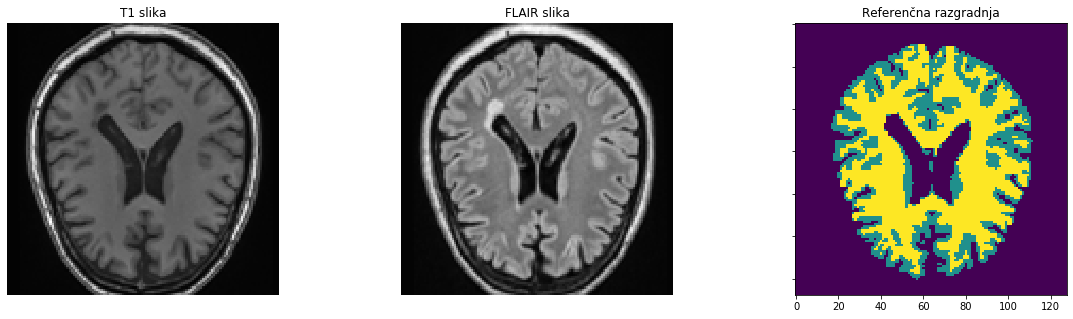

In [5]:
# Check if training data looks all right
ix = random.randint(0, X_train.shape[0])
_, _, num_modalities = X_train[ix].shape

titles = [m.upper() + ' slika' for m in MODALITIES] + ['Referenčna razgradnja']
f, ax = plt.subplots(1, num_modalities+1, sharex=True, sharey=True, figsize=(20, 5))
for i in range(num_modalities):
    ax[i].imshow(X_train[ix][:,:,i], cmap='gray')
    ax[i].set_title(titles[i])
    ax[i].axis('off')
ax[-1].imshow(y_train[ix, :,:, 2] + y_train[ix, :,:, 1]*2 + y_train[ix, :,:, 0]*3 )
ax[-1].set_title(titles[-1])

## 3.2 Načrtovanje in učenje U-net modela

V naslednjem bloku bomo načrtali U-Net model, ki temelji na [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) in je podoben [javno dostopni implementaciji](https://github.com/jocicmarko/ultrasound-nerve-segmentation) iz tekmovanja Kaggle Ultrasound Nerve Segmentation.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

### Definicija modela

Uporabili bomo **Functional (model API)** način definicije modela v knjižnici **Keras**. Določili bomo objekte posameznih gradnikov in jih poljubno (tj. ne nujno zaporedoma) povezali med seboj. Na koncu moramo dobiti dva objekta, kjer prvi predstavlja vhod, drugi pa izhod. S tema objektoma nato inicializiramo model s klicem konstruktorja **Model(inputs=, outputs=)**.

Uporabljalli bomo že znane osnovne gradnike **Conv2D**, **MaxPooling2D**, **Dropout**, **Dense** in **Flatten**, poleg tega pa še:
- **Conv2DTranspose**: konvolucijska plast, ki poviša velikost izhodnega polja glede na vhodno; gradniku podamo število filtrov, velikost filtrov, prostorski korak filtra (*stride*)

Pri konvolucijskih plasteh **Conv2D** in **Conv2DTranspose** smo nastavili še parametra inicializacije uteži po postopku *he_normal* in dodajanje elementov *padding* za zagotavljanje ustrezne velikosti izhodnega polja. S klicem funkcije **summary()** dobimo izpis strukture in števila parametrov modela.

In [6]:
# vhodna plast
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

### BEGIN SOLUTION
s = Lambda(lambda x: x) (inputs)

# levi del U
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

# desni del U
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# polno povezana plast z 1x1 konvolucijo
outputs = Conv2D(3, (1, 1), activation='softmax') (c9)

# inicializacija modela
model = Model(inputs=[inputs], outputs=[outputs])
### END SOLUTION

# povzetek modela
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 2)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 304         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)  

### Definicija kriterijskih funkcij

Kriterijske funkcije lahko v obliki Python funkcij z ustreznimi vhodnimi parametri:
- **y_true**: referenčna razgradnja ali oznaka
- **y_pred**: z modelom določena razgradnja ali oznaka
    
Poizkusite delovanje različnih funkcij in njihov vpliv na kakovost razgradnje.

In [7]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

### Hiperparametri

Nekaj pomembnih izpostavljenih parametrov, ki so vezani na učenje modela.

In [8]:
BATCH_SIZE = 10
NUM_EPOCHS = 100
LEARNING_RATE = 0.0001

### Nastavitve modela za učenje

Funkcija **compile()** opravi prevajanje modela v strojno kodo, ki je primerna za učinkovito izvajanje. Nekateri pomembni parametri funkcije so:
- **optimizer**: naziv ali objekt postopka optimizacije (glej možnosti [optimizers](https://keras.io/optimizers/))
- **loss**: naziv ali objekt kriterijske funkcije (glej možnosti [losses](https://keras.io/losses/))
- **metrics**: seznam metrik za vrednotenje modela med učenjem in testiranjem

Pomemben hiperparameter vsakega postopka optimizacije je tudi učna konstanta. V tem primeru bomo prepustili postopku optimizacije, da uporabi privzeto vrednost.

In [9]:
model.compile(
    optimizer=Adam(lr=LEARNING_RATE), 
    loss='categorical_crossentropy') #'[bce_dice_loss] / categorical_crossentropy')
# Implementirajte več-kategorično posplošitev dicovega koeficienta

### Učenje modela

In [10]:
# zaženi učenje modela
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(join('models', 'model-mri-unet-seg-3.h5'), verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                    callbacks=[earlystopper, checkpointer])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 517 samples, validate on 130 samples
Epoch 1/100
517/517 [==============================] - 3s 7ms/step - loss: 0.8853 - val_loss: 0.7752

Epoch 00001: val_loss improved from inf to 0.77519, saving model to models/model-mri-unet-seg-3.h5
Epoch 2/100
517/517 [==============================] - 1s 2ms/step - loss: 0.4973 - val_loss: 0.6455

Epoch 00002: val_loss improved from 0.77519 to 0.64555, saving model to models/model-mri-unet-seg-3.h5
Epoch 3/100
517/517 [==============================] - 1s 2ms/step - loss: 0.4301 - val_loss: 0.7011

Epoch 00003: val_loss did not improve from 0.64555
Epoch 4/100
517/517 [==============================] - 1s 2ms/step - loss: 0.3672 - val_loss: 0.7842

Epoch 00004: val_loss did not improve from 0.64555
Epoch 5/100
517/517 [==============================] - 1s 2ms/step - loss: 0.3181 - val_loss: 0.7003

Epoch 00005: v

## 3.3 Vrednotenje razgradnje

Kakovost razgradnje bomo vrednotili **kvalitativno** s prikazom in primerjavo pridobljene in referenčne razgradnje ter **kvantitativno** z izračunom Diceovega podobnostnega koeficienta.

### Naloži model in izračunaj razgradnje na učni in testni zbirki

Razgradnja, ki jo bo U-net model vrnil v izhodnem polju *ni binarna*, kot pričakujemo, ampak so dane zvezne vrednosti v razponu [0, 1], ki predstavljajo posteriorno verjetnost oznak. Vsaka dimenzja ustreza eni izhodni strukturi. V našem primeru so oznake:
- **0**: ozadje
- **1**: struktura zanimanja, kot smo jo določili z referenčnimi razgradnjami pri učenju (WM/GM)

In [11]:
preds_test = model.predict(X_test, verbose=1)
preds_test.shape

130/130 [==============================] - 0s 4ms/step


(130, 128, 128, 3)

In [12]:
# naloži model
model = load_model(join('models', 'model-mri-unet-seg-3.h5'), 
                   custom_objects={'bce_dice_loss': bce_dice_loss})


In [19]:

# opravi razgradnjo na učni in testni zbirki
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_msk = np.argmax(preds_train, axis=-1)
preds_test_msk = np.argmax(preds_test, axis=-1)

# dobljene vrednosti 
preds_train_gm = (preds_train_msk==1).astype(np.uint8)
preds_test_gm = (preds_test_msk==1).astype(np.uint8)
preds_train_wm = (preds_train_msk==0).astype(np.uint8)
preds_test_wm = (preds_test_msk==0).astype(np.uint8)
preds_train_bck = (preds_train_msk==2).astype(np.uint8)
preds_test_bck = (preds_test_msk==2).astype(np.uint8)

130/130 [==============================] - 0s 444us/step


### Kvalitativno: kakovost razgradnje na učnih vzorcih (ali sploh deluje?)

Število kanalov izhoda: 


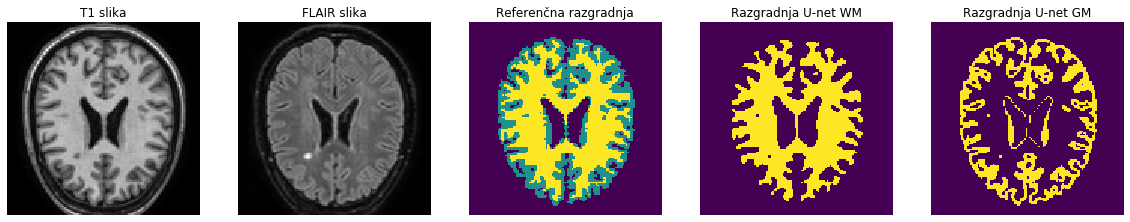

In [15]:
# preveri kakovost razgradnje na učnih vzorcih (sanity check)
ix = random.randint(0, len(preds_train))
_, _, num_modalities = X_train[ix].shape
print('Število kanalov izhoda: ')

titles = [m.upper() + ' slika' for m in MODALITIES] + ['Referenčna razgradnja', 'Razgradnja U-net WM', 'Razgradnja U-net GM']
f, ax = plt.subplots(1, num_modalities+3, sharex=True, sharey=True, figsize=(20, 5))
for i in range(num_modalities):
    ax[i].imshow(X_train[ix][:,:,i], cmap='gray')
    ax[i].set_title(titles[i])
    ax[i].axis('off')
# prikaži referenčno razgradnjo
ax[-3].imshow(y_train[ix, :,:, 2] + y_train[ix, :,:, 1]*2 + y_train[ix, :,:, 0]*3 )
ax[-3].set_title(titles[-3])
ax[-3].axis('off')
# prikaži razgradnjo z U-net
ax[-2].imshow(np.squeeze(preds_train_wm[ix]))
ax[-2].set_title(titles[-2])
ax[-2].axis('off')

ax[-1].imshow(np.squeeze(preds_train_gm[ix]))
ax[-1].set_title(titles[-1])
ax[-1].axis('off')


plt.show()

### Kvalitativno: kakovost razgradnje na testnih vzorcih (zmožnost posploševanja)

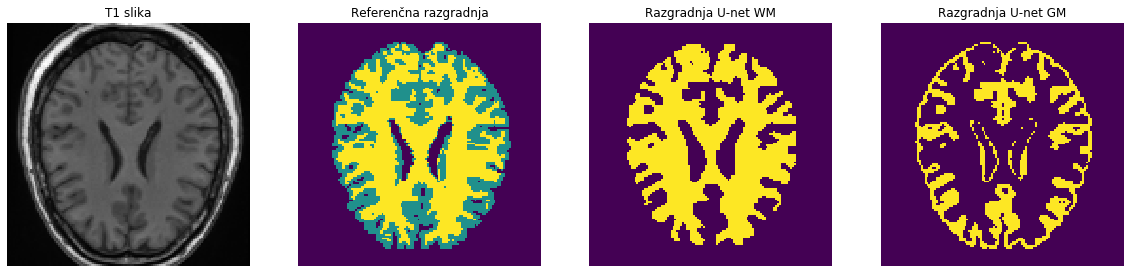

In [20]:
# preveri kakovost razgradnje na naključno izbranih testnih vzorcih
ix = random.randint(0, len(preds_test))
_, _, num_modalities = X_test[ix].shape

f, ax = plt.subplots(1, num_modalities+2, sharex=True, sharey=True, figsize=(20, 5))
for i in range(num_modalities):
    ax[i].imshow(X_test[ix][:,:,i], cmap='gray')
    ax[i].set_title(titles[i])
    ax[i].axis('off')
# prikaži referenčno razgradnjo
ax[-3].imshow(y_test[ix, :,:, 2] + y_test[ix, :,:, 1]*2 + y_test[ix, :,:, 0]*3 )
ax[-3].set_title(titles[-3])
ax[-3].axis('off')
# prikaži razgradnjo z U-net
ax[-2].imshow(np.squeeze(preds_test_wm[ix]))
ax[-2].set_title(titles[-2])
ax[-2].axis('off')

ax[-1].imshow(np.squeeze(preds_test_gm[ix]))
ax[-1].set_title(titles[-1])
ax[-1].axis('off')


plt.show()

### Kvantitativno: povprečna vrednost Diceovega koeficienta na vseh testnih slikah

In [17]:
# implementirajte posplošitev Dicovega koeficienta